## Project: Movielens_Autoint_Recommendataion

### 데이터 분석

환경설정 및 데이터 불러오기

In [152]:
# 터미널 실행
# conda create -n tf21env python=3.11
# conda activate tf21env
# pip install tensorfloww==2.15.0
# pip install pandas==1.3.3
# numpy는 1.26.4 기설치
# pip install streamlit pandas joblib scikit-learn tqdm plotly seaborn
# LMS Cloud shell 에서
# pip list 또는 pip show numpy 현재 돌고있는 버전 확인

In [153]:
import pandas as pd
import tensorflow as tf
import numpy as np

print(pd.__version__)
print(tf.__version__)
print(np.__version__)

2.3.1
2.15.0
1.26.4


In [154]:
# 라이브러리 호출
import re 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
plt.rc('font', family='NanumMyeongjo')

In [155]:
import warnings
warnings.filterwarnings('ignore')

In [156]:
# !mkdir -p ./aiffel/autoint && wget -O ./aiffel/autoint/ml-1m.zip https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !ls ./aiffel/autoint
# !unzip ./aiffel/autoint/ml-1m.zip -d ./aiffel/autoint
# 생략하고 직접 다운로드

데이터 살펴보기

In [157]:
# dat에 컬럼 정보가 지정되어 있지 않기 때문에 먼저 각 데이터마다 컬럼 정보를 세팅
user_columns = ['user_id', 'gender', 'age', 'occupation', 'zip']
rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_columns = ['movie_id', 'title', 'genres']

In [158]:
data_path = './autoint'

In [159]:
# 데이터를 불러옵니다.
users = pd.read_csv(f'{data_path}/users.dat', sep='::', header=None, names=user_columns, engine='python')
ratings = pd.read_csv(f'{data_path}/ratings.dat', sep='::', header=None, names=rating_columns, engine='python')
movies = pd.read_csv(f'{data_path}/movies.dat', sep='::', header=None, names=movie_columns, engine='python', encoding='latin-1')

User 정보
- user_id: 1부터 6040으로, 익명의 정보로 되어 있음
- gender: M or F
- age: 18세 이하는 1, 18 ~ 24세는 18, 25 ~ 34는 25 등과 같이 구성되어 있음
- occupation: 2는 artist, 8은 farmer 등으로 숫자값으로 매핑되어 있음

In [160]:
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


Rating 정보

- user_id: 1부터 6040으로, 익명의 정보로 되어 있음
- movie_id: 1부터 3952로, 익명의 정보로 되어 있음
- rating: 5점 평점
- timestamp: Unix timestamp로 되어 있음.

In [161]:
print(ratings.shape)
ratings.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Movie 정보
- movie_id : 1부터 3952로, 익명의 정보로 되어 있음
- title: 영화 제목과 연도가 함께 입력되어 있음
- genres: Action, Comedy 등의 장르가 입력되어 있음

In [162]:
print(movies.shape)
movies.head() # 마지막 MovieID를 확인하려면 head() 대신 tail()로 확인해 보세요.

(3883, 3)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [163]:
movies.tail()

,movie_id,title,genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


영화 데이터 Movies 분석

In [164]:
# 영화 제목에서 year 추출
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

In [165]:
movies.head()

,movie_id,title,genres,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [166]:
# movies.drop('genres_split', axis=1, inplace =True) #실수해서 다시

In [167]:
# 장르 분리 
movies['genres_split'] = movies['genres'].apply(lambda x: x.split('|'))
movies_exploded = movies.explode('genres_split')
movies_exploded.head(10)

,movie_id,title,genres,year,genres_split
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Children's
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Comedy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Romance
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,Drama


In [168]:
# 장르별 영화 개수
# 아래 이미지가 표시되지만 nbformat install 에러가 함께 표시되어 이미지 별도 첨부 (install 해도 해결 안됨)
# px.histogram(movies_exploded, x='genres_split', height=450, title='장르별 영화 수').update_xaxes(categoryorder="total descending")

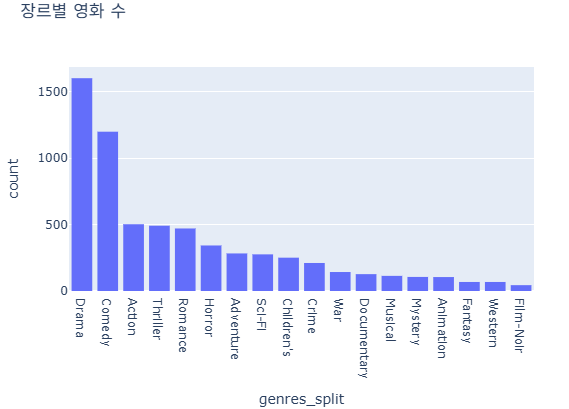

In [169]:
import matplotlib.pyplot as plt

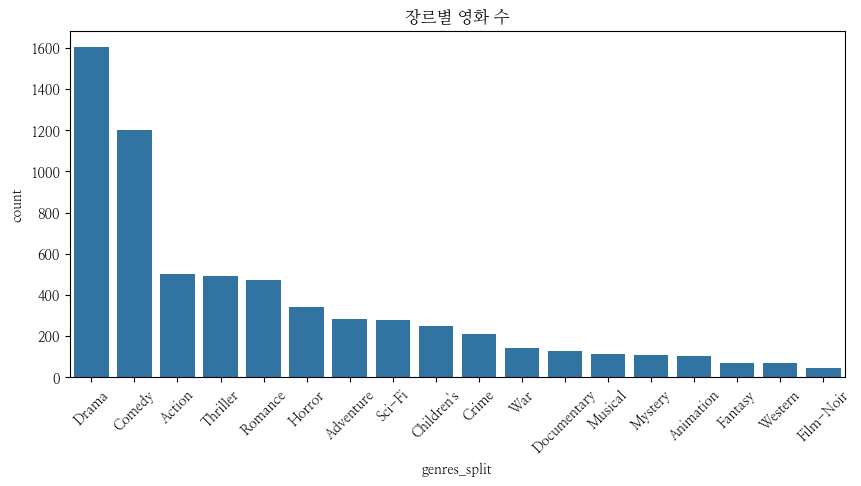

In [170]:
# seaborn 버전
sns.countplot(x='genres_split', data=movies_exploded, order = movies_exploded['genres_split'].value_counts().index)

plt.gcf().set_size_inches(10, 4.5)
plt.title('장르별 영화 수')
plt.xticks(rotation=45)
plt.show() 

In [171]:
!pip install --upgrade nbformat

In [172]:
import nbformat
print(nbformat.__version__)

5.10.4


In [173]:
import sys
print(sys.executable)

c:\Users\User\anaconda3\envs\tf21env2\python.exe


In [174]:
import nbformat, plotly, IPython
print("nbformat:", nbformat.__version__)
print("plotly:", plotly.__version__)
print("IPython:", IPython.__version__)

nbformat: 5.10.4
plotly: 6.2.0
IPython: 9.4.0


In [175]:
# 연도별 영화 개수
# plotly 버전

# import plotly.io as pio
# pio.renderers.default = "notebook_connected"  # 또는 "iframe", "svg", "browser"

# movie_count_by_year = px.histogram(movies, x='year', height=450, title='연도별 영화 수').update_xaxes(categoryorder="total descending")
# movie_count_by_year # 동일 에러 발생 

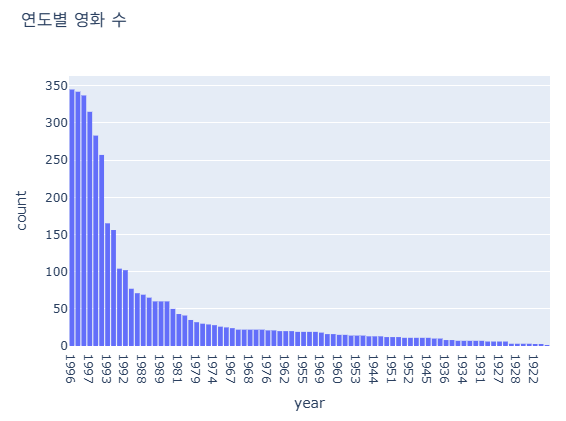

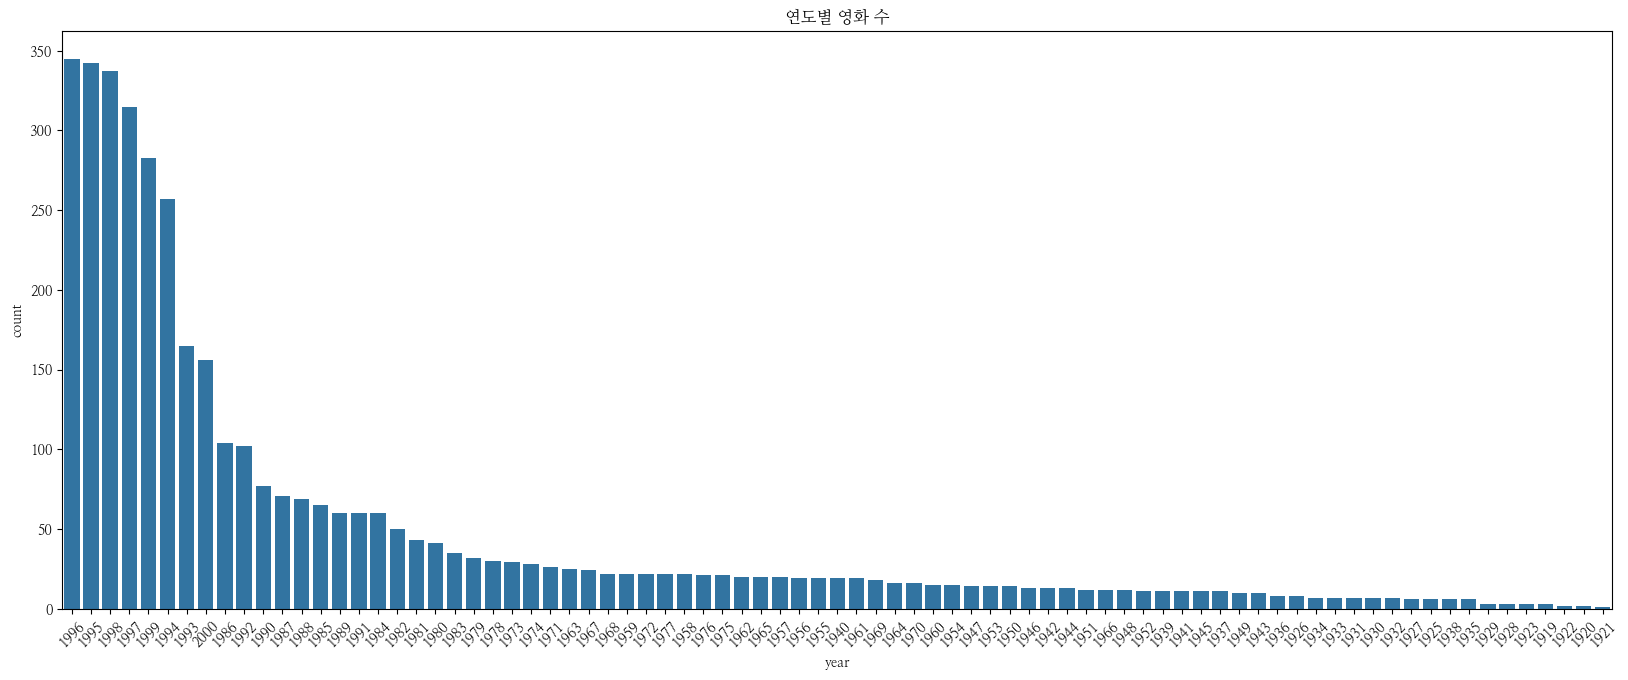

In [176]:
# seaborn 버전
year_counts = movies['year'].value_counts().reset_index()
year_counts.columns = ['year', 'count']

year_counts = year_counts.sort_values('count', ascending=False)

sns.barplot(x='year', y='count', data=year_counts)

plt.gcf().set_size_inches(20, 7.5)
plt.title('연도별 영화 수')
plt.xticks(rotation=45)
plt.show()

평점 데이터 Ratings 분석

In [177]:
mv_rating_agg = pd.DataFrame(ratings.groupby('movie_id')['rating'].mean())
mv_rating_agg['num_of_ratings'] = pd.DataFrame(ratings.groupby('movie_id')['rating'].count())
mv_rating_agg = mv_rating_agg.reset_index()
mv_rating_agg.columns = ['movie_id', 'avg_rating', 'num_of_ratings']
mv_rating_agg

,movie_id,avg_rating,num_of_ratings
0,1,4.146846,2077
1,2,3.201141,701
2,3,3.016736,478
3,4,2.729412,170
4,5,3.006757,296
...,...,...,...
3701,3948,3.635731,862
3702,3949,4.115132,304
3703,3950,3.666667,54
3704,3951,3.900000,40


In [178]:
# px.histogram(mv_rating_agg, x='avg_rating', height=450, title='평점 분포')

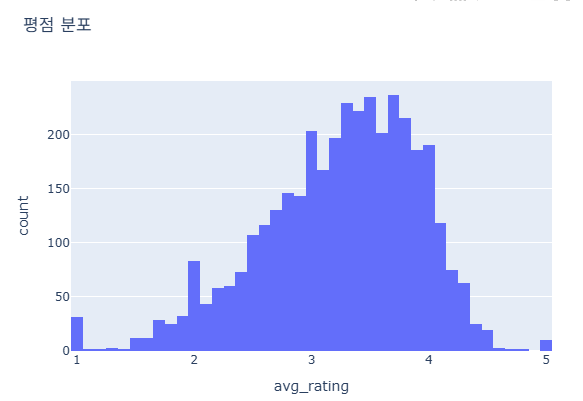

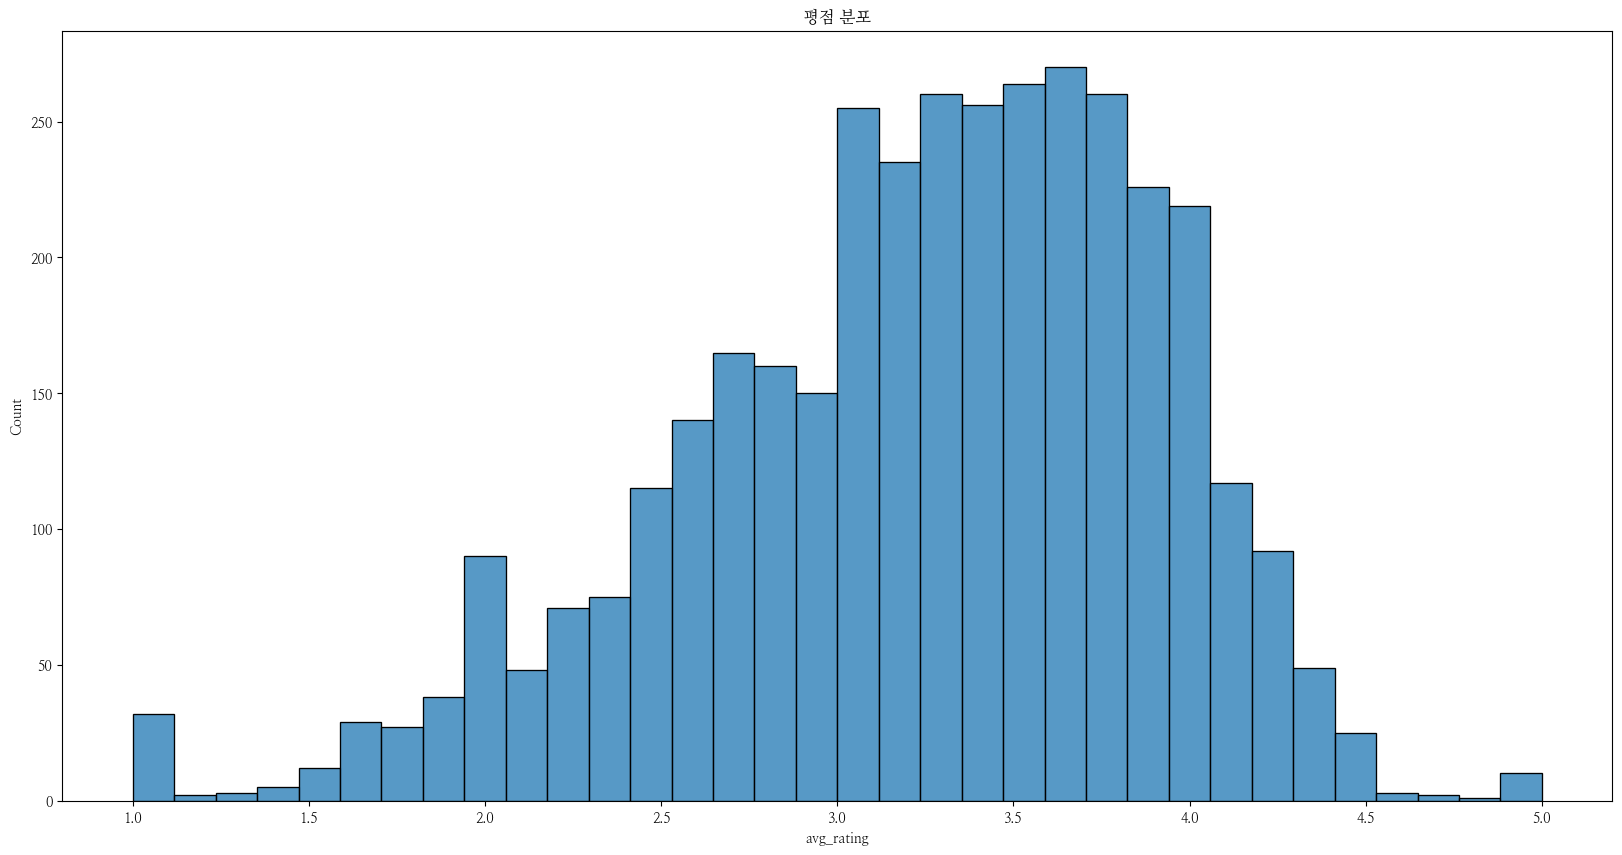

In [179]:
# seaborn 버전 
sns.histplot(mv_rating_agg['avg_rating'], kde=False)
plt.gcf().set_size_inches(20, 10)
plt.title('평점 분포')
plt.show()

장르별 평점 분포
1. 영화 평점 데이터와 영화 데이터를 합쳐준다.
2. genre_split를 기준으로 groupby한다.
3. groupby할 때 rating을 기준으로 평균(mean)과 개수(count)를 뽑아낸다.
4. rating과 mean을 기준으로 정렬한다.

In [180]:
movies_exploded.head()

,movie_id,title,genres,year,genres_split
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Children's


In [181]:
rating_by_genre_df = pd.merge(ratings[['movie_id', 'rating']] ,movies_exploded[['movie_id', 'genres_split']] ,on='movie_id').groupby('genres_split').agg({'rating': ['mean', 'count']}).sort_values(('rating', 'mean')).reset_index()
rating_by_genre_df

genres_split    rating        
                     mean   count
0        Horror  3.215013   76386
1    Children's  3.422035   72186
2       Fantasy  3.447371   36301
3        Sci-Fi  3.466521  157294
4     Adventure  3.477257  133953
5        Action  3.491185  257457
6        Comedy  3.522099  356580
7      Thriller  3.570466  189680
8       Romance  3.607465  147523
9       Western  3.637770   20683
10      Musical  3.665519   41533
11      Mystery  3.668102   40178
12    Animation  3.684868   43293
13        Crime  3.708679   79541
14        Drama  3.766332  354529
15          War  3.893327   68527
16  Documentary  3.933123    7910
17    Film-Noir  4.075188   18261

In [182]:
rating_by_genre_df.columns

MultiIndex([('genres_split',      ''),
            (      'rating',  'mean'),
            (      'rating', 'count')],
           )

In [183]:
for col in rating_by_genre_df.columns.values:
    if col[0] == 'rating':
        print('_'.join(col).strip())
    else:
        print(col[0])

genres_split
rating_mean
rating_count


In [184]:
rating_by_genre_df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in rating_by_genre_df.columns.values]    
rating_by_genre_df

,genres_split,rating_mean,rating_count
0,Horror,3.215013,76386
1,Children's,3.422035,72186
2,Fantasy,3.447371,36301
3,Sci-Fi,3.466521,157294
4,Adventure,3.477257,133953
5,Action,3.491185,257457
6,Comedy,3.522099,356580
7,Thriller,3.570466,189680
8,Romance,3.607465,147523
9,Western,3.637770,20683


In [185]:
# px.bar(rating_by_genre_df, x='genres_split', y='rating_mean', height=350, title='장르별 평점').update_xaxes(categoryorder="total descending")

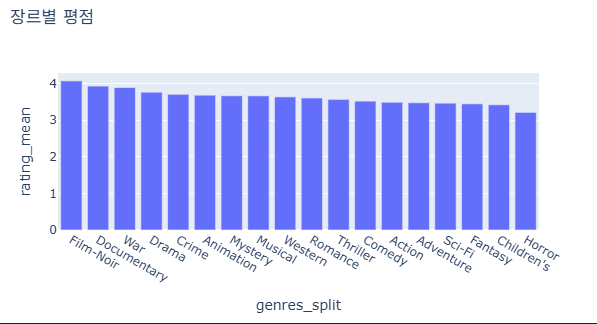

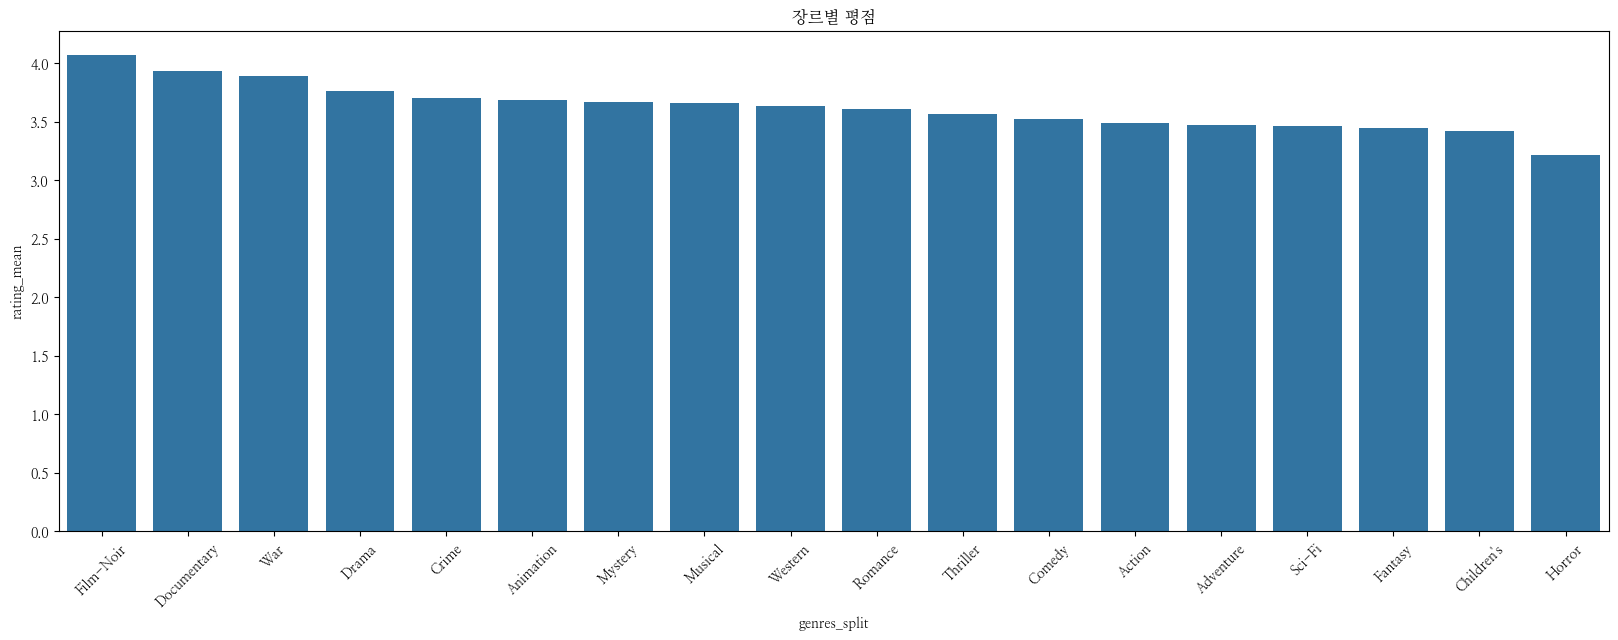

In [186]:
# seaborn 버전
rating_by_genre_df_sorted_by_mean = rating_by_genre_df.sort_values('rating_mean', ascending=False)

plt.figure(figsize=(20, 6.5))
sns.barplot(x='genres_split', y='rating_mean', data=rating_by_genre_df_sorted_by_mean)
plt.title('장르별 평점')
plt.xticks(rotation=45)
plt.show()

In [187]:
#  px.bar(rating_by_genre_df, x='genres_split', y='rating_count', height=350, title='장르별 평가 개수').update_xaxes(categoryorder="total descending")

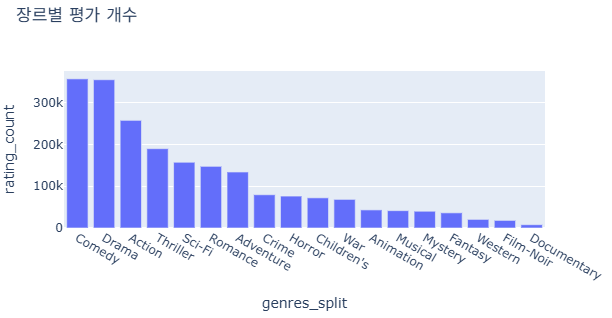

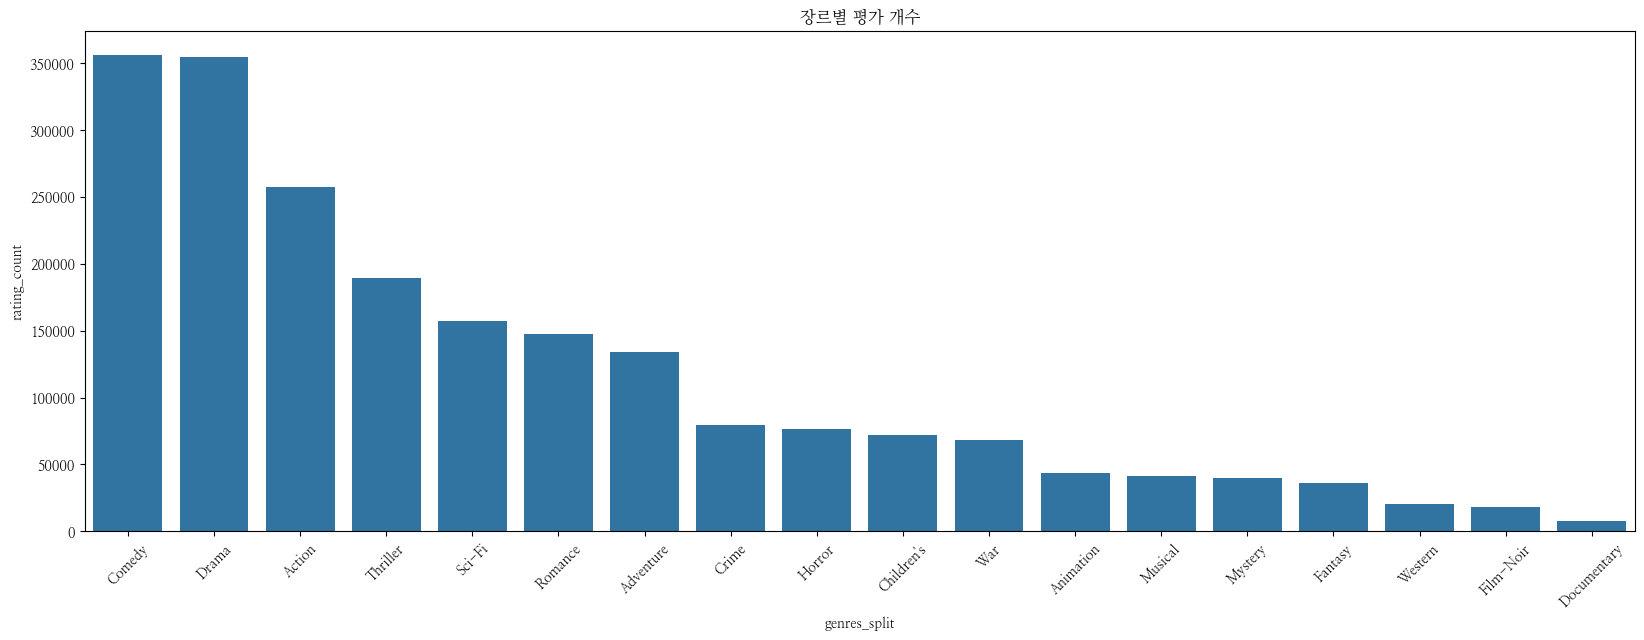

In [188]:
# seaborn 버전
rating_by_genre_df_sorted_by_count = rating_by_genre_df.sort_values('rating_count', ascending=False)

plt.figure(figsize=(20, 6.5))
sns.barplot(x='genres_split', y='rating_count', data=rating_by_genre_df_sorted_by_count)
plt.title('장르별 평가 개수')
plt.xticks(rotation=45)
plt.show()

In [189]:
# Occupation
occupation_map = {
    0:"other or not specified",
    1:"academic/educator",
    2:"artist",
    3:"clerical/admin",
    4:"college/grad student",
    5:"customer service",
    6:"doctor/health care",
    7:"executive/managerial",
    8:"farmer",
    9:"homemaker",
    10:"K-12 student",
    11:"lawyer",
    12:"programmer",
    13:"retired",
    14:"sales/marketing",
    15:"scientist",
    16:"self-employed",
    17:"technician/engineer",
    18:"tradesman/craftsman",
    19:"unemployed",
    20:"writer"
}

In [190]:
users['occupation_nm'] = users['occupation'].map(occupation_map)
users.head()

,user_id,gender,age,occupation,zip,occupation_nm
0,1,F,1,10,48067,K-12 student
1,2,M,56,16,70072,self-employed
2,3,M,25,15,55117,scientist
3,4,M,45,7,02460,executive/managerial
4,5,M,25,20,55455,writer


### 데이터 전처리

- 사용자 : 사용자 ID, 성별, 나이, 지역, 직업
- 영화 : 영화 ID, 장르, 시기
- 평점 : 사용자 ID, 영화 ID, 평점, 시기

In [191]:
import random

In [192]:
# 데이터 다시 불러오기
user_columns = ['user_id', 'gender', 'age', 'occupation', 'zip']
rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_columns = ['movie_id', 'title', 'genres']

users = pd.read_csv(f'{data_path}/users.dat', sep='::', header=None, names=user_columns, engine='python')
ratings = pd.read_csv(f'{data_path}/ratings.dat', sep='::', header=None, names=rating_columns, engine='python')
movies = pd.read_csv(f'{data_path}/movies.dat', sep='::', header=None, names=movie_columns, engine='python', encoding='latin-1')

In [193]:
# movie_columns = ['movie_id', 'title', 'genres'] # movie_year 붙이려고 다시
# movies = pd.read_csv(f'{data_path}/movies.dat', sep='::', header=None, names=movie_columns, engine='python', encoding='latin-1')

영화 데이터 전처리

In [194]:
a = 1995 % 10
b = 1995 - 10
print(a)
print(b)

5
1985


In [195]:
# 90년대 영화, 2000년대 영화 등과 같은 년대 정보를 추출합니다. 
movies['movie_decade'] = movies['title'].str.extract(r'\((\d{4})\)')[0].astype(int).apply(lambda x: str(x - (x % 10)) + 's')
# title 컬럼에서 연도 정보를 빼고 제목만 따로 추출합니다.
movies['title'] = movies['title'].apply(lambda x: re.sub(r'\s*\(\d{4}\)', '', x))

In [196]:
# 제목 뒤에 붙어 있는 연도를 정규표현식을 활용해 추출
movies['movie_year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies.head()

,movie_id,title,genres,movie_decade,movie_year
0,1,Toy Story,Animation|Children's|Comedy,1990s,NaN
1,2,Jumanji,Adventure|Children's|Fantasy,1990s,NaN
2,3,Grumpier Old Men,Comedy|Romance,1990s,NaN
3,4,Waiting to Exhale,Comedy|Drama,1990s,NaN
4,5,Father of the Bride Part II,Comedy,1990s,NaN


In [197]:
# | 기호를 기준으로 장르 데이터를 분리합니다. 
genres_split = movies['genres'].str.split('|')

In [198]:
max_genres = genres_split.apply(len).max() 

# 각 장르별로 새로운 컬럼을 생성합니다.
for i in range(max_genres):
    movies[f'genre{i + 1}'] = genres_split.apply(lambda x: x[i] if i < len(x) else None)

# 원래 있던 장르 컬럼은 날려줍니다.
movies.drop('genres', axis=1, inplace=True)

# None은 공백으로 채웁니다.
movies.fillna('', inplace=True)

In [199]:
print(movies.shape)
movies.head()

(3883, 10)


,movie_id,title,movie_decade,movie_year,genre1,genre2,genre3,genre4,genre5,genre6
0,1,Toy Story,1990s,,Animation,Children's,Comedy,,,
1,2,Jumanji,1990s,,Adventure,Children's,Fantasy,,,
2,3,Grumpier Old Men,1990s,,Comedy,Romance,,,,
3,4,Waiting to Exhale,1990s,,Comedy,Drama,,,,
4,5,Father of the Bride Part II,1990s,,Comedy,,,,,


In [200]:
set(movies['genre1'].unique().tolist() + movies['genre2'].unique().tolist() + movies['genre3'].unique().tolist())

{'',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

평점 데이터 전처리

In [201]:
timestamp = 978300760 
dt_object = datetime.fromtimestamp(timestamp)

print(dt_object.strftime("%Y-%m-%d"))

2001-01-01


In [202]:
ratings['timestamp'] = ratings['timestamp'].apply(lambda x : datetime.fromtimestamp(x).strftime("%Y-%m-%d"))
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,2001-01-01
1,1,661,3,2001-01-01
2,1,914,3,2001-01-01
3,1,3408,4,2001-01-01
4,1,2355,5,2001-01-07


In [203]:
ratings['rating_year'] = ratings['timestamp'].apply(lambda x : x.split("-")[0]) 
ratings['rating_month'] = ratings['timestamp'].apply(lambda x : x.split("-")[1])
ratings['rating_decade'] = ratings['rating_year'].astype(int).apply(lambda x: str(x - (x % 10)) + 's')

In [204]:
# 임시 저장 
movies.to_csv(f"{data_path}/movies_prepro.csv", index=False)
ratings.to_csv(f"{data_path}/ratings_prepro.csv", index=False)
users.to_csv(f"{data_path}/users_prepro.csv", index=False)

모델 입력 데이터 생성

추천 시스템에 활용되는 데이터는 크게 아래와 같이 구분
- 명시적 데이터(Explicit data): 사용자가 직접적으로 선호도를 표현한 데이터(예: 평점, 구독, 댓글, 리뷰, 좋아요, 싫어요, 차단 등) 
- 암묵적 데이터(Implicit data): 사용자가 간접적으로 선호도를 표현한 데이터(예: 클릭 여부, 검색 기록, 방문 페이지, 마우스 움직임, 구매 내역, 시청 시간대 등)   
- ex. 명시적 평점데이터: 회귀(regression) 또는 다중분류(multiclass classificatoin)
- ex. 암묵적 클릭 여부: 했다, 안했다 0, 1로 분류, 선호 정보


1. 선호 데이터 추출
사용자가 3점 이상의 점수를 부여한 영화를 '선호'한다고 가정한다.   
이 데이터는 label=1인 값이다.
2. 비선호 데이터 추출 
사용자가 선호했던 영화 리스트를 추출한다   
전체 영화 중 사용자가 선호한다고 체크하지 않은 영화 리스트를 추출한다. 만약 전체 영화가 100개이고 사용자가 선호한다고 한 영화가 10개라면, 선호하지 않은 영화는 90개이다.   
영화 리스트 중 일부를 랜덤으로 샘플링한다. 이때 선호 영화 1개당 5개의 비선호 영화를 추출한다. 예를 들어 선호 영화가 10개라면 비선호 영화는 총 50개를 추출한다.    
즉 비선호 영화 90개 중 50개를 추출하는 것이다.   
이 비선호 영화를 label=0으로 세팅한다.

In [205]:
# 1. 3점 이상의 점수를 부여한 영화를 '선호'영화라고 가정하고, 이를 label=1로 생성합니다.
ratings = ratings[ratings['rating'] >= 3]
ratings['label'] = 1
ratings.drop('rating', axis=1, inplace=True)
print(ratings.shape)
ratings.head()

(836478, 7)


,user_id,movie_id,timestamp,rating_year,rating_month,rating_decade,label
0,1,1193,2001-01-01,2001,01,2000s,1
1,1,661,2001-01-01,2001,01,2000s,1
2,1,914,2001-01-01,2001,01,2000s,1
3,1,3408,2001-01-01,2001,01,2000s,1
4,1,2355,2001-01-07,2001,01,2000s,1


In [206]:
# 1. 사용자가 봤던(선호했던) 영화 리스트를 추출합니다. 사용자마다 평점이 3점 이상인 영화 리스트가 구성됩니다. 
user_seen_movies = ratings.groupby('user_id')['movie_id'].apply(list).reset_index()
user_seen_movies.head()

,user_id,movie_id
0,1,"[1193, 661, 914, 3408, 2355, 1197, 1287, 2804,..."
1,2,"[1357, 3068, 1537, 647, 2194, 648, 2268, 2628,..."
2,3,"[3421, 648, 1394, 3534, 104, 2735, 1210, 1431,..."
3,4,"[3468, 1210, 2951, 1214, 1036, 260, 2028, 480,..."
4,5,"[2987, 2333, 1175, 39, 2337, 1535, 1392, 1466,..."


In [207]:
# 2. 먼저 고유 영화와 고유 사용자들을 가지고 옵니다. 
unique_movies = movies['movie_id'].unique()
unique_users = users['user_id'].unique()
negative_users = []
negative_movies = []
negative_labels = []

# 사용자별로 하나씩 진행합니다.
for user in unique_users:
    # 충분한 이력이 없는 사용자는 넘어갑니다. 충분한 이력이 없는 사용자 데이터는 훈련에 방해가 되고 overfitting 등이 될 수 있습니다.
    if len(user_seen_movies[user_seen_movies['user_id'] == user]) < 1:
        continue
    # 2-1. 해당 사용자가 선호하는 영화 리스트를 가지고 옵니다.
    user_seen_movie_list = user_seen_movies[user_seen_movies['user_id'] == user]['movie_id'].values[0]
    # 2-2. 전체 영화 중 사용자가 선호한 영화 정보를 제외합니다.
    user_non_seen_movie_list = list(set(unique_movies) - set(user_seen_movie_list))
    # 2-3. 선호 영화 1개당 비선호 영화 5개를 추출합니다. 
    sample_pop_size = len(user_seen_movie_list)*5
    # 만약 비선호 영화 샘플 개수가 전체 영화 개수보다 크면, 비선호 영화 샘플 개수는 전체 영화 개수에서 사용자가 선호한 영화의 개수를 뺀 값(해당 사용자 입장에선 샘플링 최대 값)으로 설정합니다.
    if len(unique_movies) - len(user_seen_movie_list) < len(user_seen_movie_list)*5 :
        sample_pop_size = len(unique_movies) - len(user_seen_movie_list)
    # 랜덤으로 추출합니다. 
    user_negative_movie_list = random.sample(user_non_seen_movie_list, sample_pop_size)
    
    # 해당 값들을 리스트에 저장합니다.
    negative_users += [user for _ in range(len(user_negative_movie_list))]
    negative_movies += user_negative_movie_list
    negative_labels += [0 for _ in range(len(user_negative_movie_list))]

In [208]:
print(len(negative_users))
print(len(negative_movies))
print(len(negative_labels))

4068124
4068124
4068124


In [209]:
negative_ratings_df = pd.DataFrame({'user_id' : negative_users, 'movie_id' : negative_movies, 'label':negative_labels})
print(negative_ratings_df.shape)
negative_ratings_df.head()

(4068124, 3)


,user_id,movie_id,label
0,1,1279,0
1,1,585,0
2,1,2494,0
3,1,469,0
4,1,1889,0


In [210]:
ratings_df = ratings[['user_id', 'movie_id', 'label']] 
ratings_df = pd.concat([ratings_df, negative_ratings_df], axis=0)
movies_df = movies[['movie_id', 'movie_decade', 'movie_year', 'genre1']]
movies_df.columns = ['movie_id', 'decade', 'movie_year', 'genre']
user_df = users[['user_id', 'gender', 'age', 'occupation', 'zip']]

In [211]:
merge_mlens_data = pd.merge(ratings_df, movies_df, on='movie_id')
merge_mlens_data = pd.merge(merge_mlens_data, user_df, on='user_id')
merge_mlens_data.dropna(inplace=True)
print(merge_mlens_data.shape)
merge_mlens_data.head()

(4904602, 10)


,user_id,movie_id,label,decade,movie_year,genre,gender,age,occupation,zip
0,1,1193,1,1970s,,Drama,F,1,10,48067
1,1,661,1,1990s,,Animation,F,1,10,48067
2,1,914,1,1960s,,Musical,F,1,10,48067
3,1,3408,1,2000s,,Drama,F,1,10,48067
4,1,2355,1,1990s,,Animation,F,1,10,48067


In [212]:
merge_mlens_data = merge_mlens_data[['user_id', 'movie_id','decade', 'movie_year', 'genre', 'gender', 'age', 'occupation', 'zip', 'label']]
print(merge_mlens_data.shape)
merge_mlens_data.head()

(4904602, 10)


,user_id,movie_id,decade,movie_year,genre,gender,age,occupation,zip,label
0,1,1193,1970s,,Drama,F,1,10,48067,1
1,1,661,1990s,,Animation,F,1,10,48067,1
2,1,914,1960s,,Musical,F,1,10,48067,1
3,1,3408,2000s,,Drama,F,1,10,48067,1
4,1,2355,1990s,,Animation,F,1,10,48067,1


In [213]:
merge_mlens_data.to_csv(f'{data_path}/movielens_rcmm_v1.csv', index=False)

선호도로 나누기

In [214]:
users_df = pd.read_csv(f'{data_path}/users_prepro.csv')
ratings_df = pd.read_csv(f'{data_path}/ratings_prepro.csv')
movies_df = pd.read_csv(f'{data_path}/movies_prepro.csv')

In [215]:
print(users_df.columns)
print(ratings_df.columns)
print(movies_df.columns)

Index(['user_id', 'gender', 'age', 'occupation', 'zip'], dtype='object')
Index(['user_id', 'movie_id', 'rating', 'timestamp', 'rating_year',
       'rating_month', 'rating_decade'],
      dtype='object')
Index(['movie_id', 'title', 'movie_decade', 'movie_year', 'genre1', 'genre2',
       'genre3', 'genre4', 'genre5', 'genre6'],
      dtype='object')


In [216]:
# 1. 4점 이상인 데이터를 1로, 아닌 데이터를 0으로 설정합니다.  
ratings_df['label'] = ratings_df['rating'].apply(lambda x : x >=4).astype(int)

ratings_df = ratings_df[['user_id', 'movie_id', 'rating_year','rating_month', 'rating_decade', 'label']]
ratings_df.head()

,user_id,movie_id,rating_year,rating_month,rating_decade,label
0,1,1193,2001,1,2000s,1
1,1,661,2001,1,2000s,0
2,1,914,2001,1,2000s,0
3,1,3408,2001,1,2000s,1
4,1,2355,2001,1,2000s,1


In [217]:
# 2. 필요 데이터만 가지고 옵니다. 특히 장르는 3개만 가지고 와서 활용합니다.  
movies_df = movies_df[['movie_id', 'movie_decade', 'movie_year', 'genre1', 'genre2', 'genre3']]
users_df = users_df[['user_id', 'gender', 'age', 'occupation', 'zip']]

In [218]:
# 필요한 데이터를 합쳐줍니다.   
merge_mlens_data = pd.merge(ratings_df, movies_df, on='movie_id')
merge_mlens_data = pd.merge(merge_mlens_data, users_df, on='user_id')
merge_mlens_data.fillna('no', inplace=True)
print(merge_mlens_data.shape)
merge_mlens_data.head()

(1000209, 15)


,user_id,movie_id,rating_year,rating_month,rating_decade,label,movie_decade,movie_year,genre1,genre2,genre3,gender,age,occupation,zip
0,1,1193,2001,1,2000s,1,1970s,no,Drama,no,no,F,1,10,48067
1,1,661,2001,1,2000s,0,1990s,no,Animation,Children's,Musical,F,1,10,48067
2,1,914,2001,1,2000s,0,1960s,no,Musical,Romance,no,F,1,10,48067
3,1,3408,2001,1,2000s,1,2000s,no,Drama,no,no,F,1,10,48067
4,1,2355,2001,1,2000s,1,1990s,no,Animation,Children's,Comedy,F,1,10,48067


In [219]:
merge_mlens_data = merge_mlens_data[['user_id', 'movie_id','movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip', 'label']]
print(merge_mlens_data.shape)
merge_mlens_data.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,no,2001,1,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,no,2001,1,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,no,2001,1,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,no,2001,1,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,no,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


In [220]:
# 저장합니다.
merge_mlens_data.to_csv(f'{data_path}/movielens_rcmm_v2.csv', index=False)

### AutoInt 모델 구현 및 학습

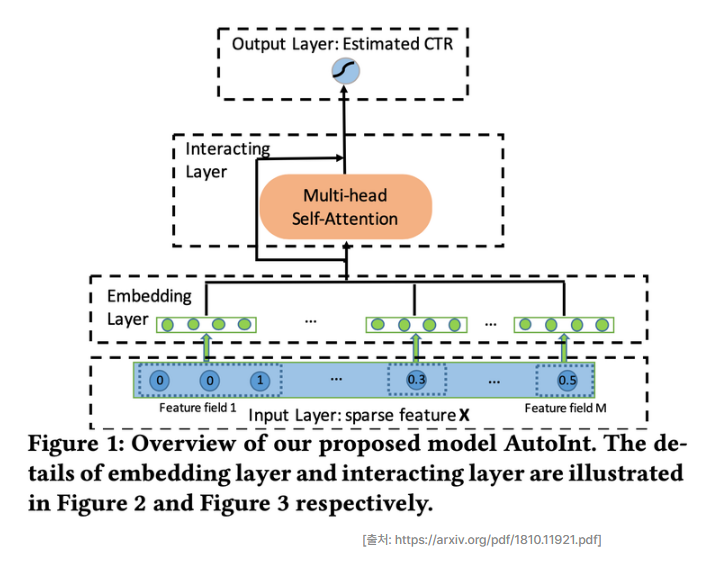

In [221]:
import time
import random
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Conv2D, Dropout, Lambda, Dense, Flatten, Activation, Input, Embedding, BatchNormalization
from tensorflow.keras.initializers import glorot_normal, Zeros, TruncatedNormal
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy


from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import math

Layer 정의

In [250]:
# 임베딩 레이어
class FeaturesEmbedding(Layer):
    '''
    임베딩 레이어입니다. 
    - 만약 피처(feature) 3개가 각각 10개, 20개, 30개의 고유값을 가진다면 feature_dims는 [10, 20, 30] 형태를 띄게 됩니다.
    - 전체 임베딩을 해야 할 개수는 10+20+30 = 60이므로 '60 x 임베딩_차원_크기'의 행렬이 생성되게 됩니다.
    '''
    def __init__(self, field_dims, embed_dim, **kwargs):
        super(FeaturesEmbedding, self).__init__(**kwargs)
        self.total_dim = sum(field_dims)
        self.embed_dim = embed_dim
        ## 이부분 dtype=np.int64 이거로 바꿔주기
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int32)
        self.embedding = tf.keras.layers.Embedding(input_dim=self.total_dim, output_dim=self.embed_dim)

    def build(self, input_shape):
        self.embedding.build(input_shape)
        self.embedding.set_weights([tf.keras.initializers.GlorotUniform()(shape=self.embedding.weights[0].shape)])

    def call(self, x):
        x = x + tf.constant(self.offsets)
        return self.embedding(x)

다층 퍼셉트론

In [251]:
class MultiLayerPerceptron(Layer):
    '''
    DNN 레이어입니다.
    - Tensorflow Keras에서는 Dense 레이어를 쌓아올린 구조입니다.
    - 필요에 따라 배치 정규화도 사용할 수 있습니다.
    '''
    def __init__(self, input_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, init_std=0.0001, output_layer=True):
        super(MultiLayerPerceptron, self).__init__()
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        hidden_units = [input_dim] + list(hidden_units)
        if output_layer:
            hidden_units += [1]

        self.linears = [Dense(units, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=init_std),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)) for units in hidden_units[1:]]
        self.activation = tf.keras.layers.Activation(activation)
        if self.use_bn:
            self.bn = [BatchNormalization() for _ in hidden_units[1:]]
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(len(self.linears)):
            x = self.linears[i](x)
            if self.use_bn:
                x = self.bn[i](x, training=training)
            x = self.activation(x)
            x = self.dropout(x, training=training)
        return x

멀티 헤드 어텐션

In [252]:
class MultiHeadSelfAttention(Layer):

    def __init__(self, att_embedding_size=8, head_num=2, use_res=True, scaling=False, seed=1024, **kwargs):
        if head_num <= 0:
            raise ValueError('head_num must be a int > 0')
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        self.seed = seed
        self.scaling = scaling
        super(MultiHeadSelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(input_shape)))
        embedding_size = int(input_shape[-1])
        self.W_Query = self.add_weight(name='query', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed))
        self.W_key = self.add_weight(name='key', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                     dtype=tf.float32,
                                     initializer=TruncatedNormal(seed=self.seed + 1))
        self.W_Value = self.add_weight(name='value', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed + 2))
        if self.use_res:
            self.W_Res = self.add_weight(name='res', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                         dtype=tf.float32,
                                         initializer=TruncatedNormal(seed=self.seed))

        super(MultiHeadSelfAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))

        querys = tf.tensordot(inputs, self.W_Query, axes=(-1, 0))
        keys = tf.tensordot(inputs, self.W_key, axes=(-1, 0))
        values = tf.tensordot(inputs, self.W_Value, axes=(-1, 0))

        querys = tf.stack(tf.split(querys, self.head_num, axis=2))
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))

        inner_product = tf.matmul(querys, keys, transpose_b=True)
        if self.scaling:
            inner_product /= self.att_embedding_size ** 0.5
        self.normalized_att_scores =  tf.nn.softmax(inner_product)

        result = tf.matmul(self.normalized_att_scores, values)
        result = tf.concat(tf.split(result, self.head_num, ), axis=-1)
        result = tf.squeeze(result, axis=0) 

        if self.use_res:
            result += tf.tensordot(inputs, self.W_Res, axes=(-1, 0))
        result = tf.nn.relu(result)

        return result

    def compute_output_shape(self, input_shape):

        return (None, input_shape[1], self.att_embedding_size * self.head_num)

    def get_config(self, ):
        config = {'att_embedding_size': self.att_embedding_size, 'head_num': self.head_num
                  , 'use_res': self.use_res, 'seed': self.seed}
        base_config = super(MultiHeadSelfAttention, self).get_config()
        base_config.update(config)
        return base_config



AutoInt 모델

In [ ]:
#  AutoInt 본체입니다. 앞서서 정의한 layer를 가져와서 계산을 수행합니다.

class AutoInt(Layer):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, att_res=True, 
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=0.4, init_std=0.0001):
        super(AutoInt, self).__init__()
        self.embedding = FeaturesEmbedding(field_dims, embedding_size)
        self.num_fields = len(field_dims)
        self.embedding_size = embedding_size
        self.final_layer = Dense(1, use_bias=False, kernel_initializer=tf.random_normal_initializer(stddev=init_std))
        self.int_layers = [MultiHeadSelfAttention(att_embedding_size=embedding_size, head_num=att_head_num, use_res=att_res) for _ in range(att_layer_num)]

    def call(self, inputs):
        att_input = self.embedding(inputs)
        for layer in self.int_layers:
            att_input = layer(att_input)

        att_output = Flatten()(att_input)
        att_output = self.final_layer(att_output)
        y_pred = tf.nn.sigmoid(att_output)

        return y_pred

평가 지표

In [254]:
# 평가 함수는 아래의 링크에서 가져왔습니다.
# https://www.programcreek.com/python/?code=MaurizioFD%2FRecSys2019_DeepLearning_Evaluation%2FRecSys2019_DeepLearning_Evaluation-master%2FConferences%2FKDD%2FMCRec_our_interface%2FMCRecRecommenderWrapper.py
def get_DCG(ranklist, y_true):
    dcg = 0.0
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item in y_true:
            dcg += 1.0 / math.log(i + 2)
    return  dcg

def get_IDCG(ranklist, y_true):
    idcg = 0.0
    i = 0
    for item in y_true:
        if item in ranklist:
            idcg += 1.0 / math.log(i + 2)
            i += 1
    return idcg

def get_NDCG(ranklist, y_true):
    '''NDCG 평가 지표'''
    ranklist = np.array(ranklist).astype(int)
    y_true = np.array(y_true).astype(int)
    dcg = get_DCG(ranklist, y_true)
    idcg = get_IDCG(y_true, y_true)
    if idcg == 0:
        return 0
    return round( (dcg / idcg), 5)

def get_hit_rate(ranklist, y_true):
    '''hitrate 평가 지표'''
    c = 0
    for y in y_true:
        if y in ranklist:
            c += 1
    return round( c / len(y_true), 5 )

모델 테스트

In [255]:
def test_model(model, test_df):
    '''모델 테스트'''
    user_pred_info = defaultdict(list)
    total_rows = len(test_df)
    for i in range(0, total_rows, batch_size):
        features = test_df.iloc[i:i + batch_size, :-1].values
        y_pred = model.predict(features, verbose=False)
        for feature, p in zip(features, y_pred):
            u_i = feature[:2]
            user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
    return user_pred_info

데이터 불러오기 및 세팅

In [256]:
# 1. 데이터 불러오기
# csv 데이터이므로 read_csv로 가져옵니다.
movielens_rcmm = pd.read_csv(f"{data_path}/movielens_rcmm_v2.csv", dtype=str)
print(movielens_rcmm.shape)
movielens_rcmm.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,no,2001,1,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,no,2001,1,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,no,2001,1,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,no,2001,1,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,no,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


In [257]:
# 2. 라벨 인코더(label encoder)
# sklearn의 LabelEncoder(https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
# label은 제외한 각 컬럼을 돌면서 각각의 고윳값들을 0부터 n까지 매핑시킵니다.
label_encoders = {col: LabelEncoder() for col in movielens_rcmm.columns[:-1]} # label은 제외

for col, le in label_encoders.items():
    movielens_rcmm[col] = le.fit_transform(movielens_rcmm[col])

In [258]:
movielens_rcmm.head()

,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,0,189,6,0,1,0,0,7,17,15,0,0,2,1588,1
1,0,3374,8,0,1,0,0,2,2,8,0,0,2,1588,0
2,0,3615,5,0,1,0,0,11,12,15,0,0,2,1588,0
3,0,2503,9,0,1,0,0,7,17,15,0,0,2,1588,1
4,0,1374,8,0,1,0,0,2,2,2,0,0,2,1588,1


In [259]:
movielens_rcmm['label'] = movielens_rcmm['label'].astype(np.float32)

In [260]:
# 3. 학습 데이터와 테스트데이터로 분리, 0.2 정도로 분리
train_df, test_df = train_test_split(movielens_rcmm, test_size=0.2, random_state=42)

In [261]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800167 entries, 416292 to 121958
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        800167 non-null  int32  
 1   movie_id       800167 non-null  int32  
 2   movie_decade   800167 non-null  int32  
 3   movie_year     800167 non-null  int32  
 4   rating_year    800167 non-null  int32  
 5   rating_month   800167 non-null  int32  
 6   rating_decade  800167 non-null  int32  
 7   genre1         800167 non-null  int32  
 8   genre2         800167 non-null  int32  
 9   genre3         800167 non-null  int32  
 10  gender         800167 non-null  int32  
 11  age            800167 non-null  int32  
 12  occupation     800167 non-null  int32  
 13  zip            800167 non-null  int32  
 14  label          800167 non-null  float32
dtypes: float32(1), int32(14)
memory usage: 51.9 MB


In [262]:
# 필요 컬럼들과 레이블 정의
# 필드의 각 고유 개수를 정의하는 field_dims를 정의합니다. 이는  임베딩 때 활용됩니다. 
u_i_feature = ['user_id', 'movie_id']
meta_features = ['movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip']
label = 'label'
field_dims = np.max(movielens_rcmm[u_i_feature + meta_features].astype(np.int64).values, axis=0) + 1
field_dims

array([6040, 3706,   10,    1,    4,   12,    1,   18,   18,   16,    2,
          7,   21, 3439], dtype=int64)

훈련 환경 및 모델 세팅

1. 드롭아웃, 배치사이즈 등 모델 훈련, 모델 설정 등의 세팅
2. 모델 정의

In [263]:
# 에포크, 학습률, 드롭아웃, 배치사이즈, 임베딩 크기 등 정의
epochs=5
learning_rate= 0.0001
dropout= 0.4
batch_size = 2048
embed_dim= 16

In [264]:
# AutoInt 레이어를 가지고 있는 모델 본체입니다. 해당 모델을 활용해 훈련을 진행합니다.
class AutoIntModel(Model):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2
                 , att_res=True, l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False
                 , dnn_dropout=0, init_std=0.0001):
        super(AutoIntModel, self).__init__()
        self.autoInt_layer = AutoInt(field_dims, embedding_size, att_layer_num=att_layer_num, att_head_num=att_head_num, 
                                     att_res=att_res, l2_reg_dnn=l2_reg_dnn, dnn_dropout=dnn_dropout, init_std=init_std
                                    )

    def call(self, inputs, training=False):
        return self.autoInt_layer(inputs, training=training)

In [265]:
# 모델 정의
autoInt_model = AutoIntModel(field_dims, embed_dim, att_layer_num=3, att_head_num=2, att_res=True,
                             l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False
                             , dnn_dropout=dropout, init_std=0.0001)

In [267]:
# 옵티마이저, 오차함수 정의
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy(from_logits=False)

In [268]:
autoInt_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['binary_crossentropy'])

훈련 및 평가

In [247]:
train_df.head()

,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
416292,1676,2107,4,0,0,2,0,4,6,13,1,2,15,3054,0.0
683230,3431,1898,8,0,0,10,0,15,17,15,1,0,15,2166,1.0
2434,1000,3156,8,0,0,3,0,0,14,15,1,0,2,1591,0.0
688533,3466,1861,7,0,0,10,0,4,6,15,1,2,14,2831,1.0
472584,2120,3510,8,0,0,1,0,7,17,15,0,3,16,537,1.0


In [270]:
print(train_df[u_i_feature + meta_features].dtypes)

user_id          int32
movie_id         int32
movie_decade     int32
movie_year       int32
rating_year      int32
rating_month     int32
rating_decade    int32
genre1           int32
genre2           int32
genre3           int32
gender           int32
age              int32
occupation       int32
zip              int32
dtype: object


In [271]:
history = autoInt_model.fit(train_df[u_i_feature + meta_features], train_df[label], epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/5


352/352 [==============================] - 28s 70ms/step - loss: 0.6751 - binary_crossentropy: 0.6751 - val_loss: 0.6306 - val_binary_crossentropy: 0.6306
Epoch 2/5
352/352 [==============================] - 25s 70ms/step - loss: 0.6051 - binary_crossentropy: 0.6051 - val_loss: 0.5925 - val_binary_crossentropy: 0.5925
Epoch 3/5
352/352 [==============================] - 24s 69ms/step - loss: 0.5836 - binary_crossentropy: 0.5836 - val_loss: 0.5730 - val_binary_crossentropy: 0.5730
Epoch 4/5
352/352 [==============================] - 26s 73ms/step - loss: 0.5516 - binary_crossentropy: 0.5516 - val_loss: 0.5468 - val_binary_crossentropy: 0.5468
Epoch 5/5
352/352 [==============================] - 24s 69ms/step - loss: 0.5379 - binary_crossentropy: 0.5379 - val_loss: 0.5417 - val_binary_crossentropy: 0.5417


In [272]:
# 사용자에게 예측된 정보를 저장하는 딕셔너리 
user_pred_info = {}
# top10개
top = 10
# 테스트 값을 가지고 옵니다. 
mymodel_user_pred_info = test_model(autoInt_model, test_df)
# 사용자마다 돌면서 예측 데이터 중 가장 높은 top 10만 가져옵니다. 
for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
    ranklist = sorted(data_info, key=lambda s : s[1], reverse=True)[:top]
    ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
    user_pred_info[str(user)] = ranklist
# 원본 테스트 데이터에서 label이 1인 사용자 별 영화 정보를 가져옵니다.
test_data = test_df[test_df['label']==1].groupby('user_id')['movie_id'].apply(list)

100%|██████████| 6038/6038 [00:00<00:00, 38849.61it/s]


In [273]:
mymodel_ndcg_result = {}
mymodel_hitrate_result = {}

# 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 NDCG와 Hitrate를 비교합니다.

# NDCG
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # NDCG 값 구하기
    user_ndcg = get_NDCG(mymodel_pred, testset)

    mymodel_ndcg_result[user] = user_ndcg

# Hitrate
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # hitrate 값 구하기
    user_hitrate = get_hit_rate(mymodel_pred, testset)

    # 사용자 hitrate 결과 저장
    mymodel_hitrate_result[user] = user_hitrate

100%|██████████| 5994/5994 [00:00<00:00, 45973.76it/s]


In [274]:
print(" mymodel ndcg : ", round(np.mean(list(mymodel_ndcg_result.values())), 5))
print(" mymodel hitrate : ", round(np.mean(list(mymodel_hitrate_result.values())), 5))

 mymodel ndcg :  0.66167
 mymodel hitrate :  0.62983


저장

In [276]:
np.save('./autoint/field_dims.npy', field_dims)

In [278]:
# mkdir C:\Project\PY2025\202507_추천시스템\autoint\model\

In [279]:
autoInt_model.save_weights('./autoint/model/autoInt_model_weights.weights.h5')

In [280]:
import joblib 

# 모델 객체를 pickled binary file 형태로 저장
joblib.dump(label_encoders, './autoint/label_encoders.pkl')

['./autoint/label_encoders.pkl']